### A Brief Introduction to Anonymization with K-Anonymity

Anonymization of data usually requires a knowledge of what potential attacks the data will face, and an understanding of possible linked data which may be available to the attacker. It is difficult to anticipate, when releasing data, what future linkage or attacks might be possible -- so it is indeed quite difficult to release useful information and determine it has been "fully" anonymized and will remain so in the future.

That said, in this notebook, we will explore several concepts related to K-Anonymity. For further review, please see the in-depth notebooks, which also contain definitions and code for exploring anonymization via K-Anonymity and measuring privacy loss with differential privacy.

In [1]:
import pandas as pd
from matplotlib import pylab as pl

# this is a list of the column names in our dataset (as the file doesn't contain any headers)
names = (
    'age',
    'workclass', #Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    'fnlwgt', # "weight" of that person in the dataset (i.e. how many people does that person represent) -> https://www.kansascityfed.org/research/datamuseum/cps/coreinfo/keyconcepts/weights
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)

# some fields are categorical and will require special treatment
categorical = set((
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country',
    'race',
    'income',
))

df = pd.read_csv("../data/k-anonymity/adult.all.txt", 
                 sep=", ", header=None, 
                 names=names, index_col=False, engine='python')

In [2]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50k
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50k
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50k
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50k
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50k


### Your Turn

- What potential sensitive data do we have? 
- How might different attacks be used on this data?
- How might we go about anonymization when thinking of K-Anonymity?

In [3]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

### Your Turn

- We need to turn each categorical column into a Pandas Categorical column

In [4]:
for column in categorical:
    df[column] = pd.Categorical(df[column])

In [5]:
from utils import split, get_spans

In [6]:
split?

In [7]:
get_spans?

In [8]:
get_spans(df, df.index)

{'age': 73,
 'workclass': 9,
 'fnlwgt': 1478115,
 'education': 16,
 'education-num': 15,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'capital-gain': 99999,
 'capital-loss': 4356,
 'hours-per-week': 98,
 'native-country': 42,
 'income': 2}

### Your Turn

- Now we need to write a function `is_k_anonymous` which allows us to test whether a partition (in this case, a set of rows) is valid.

In [9]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        # we cannot split this partition further...
        return False
    return True

### Creating a K Anonymous Dataset

Next, we need to implement the partitioning of the dataset and visualize it, to get a better understanding of the chosen partitions.

In [10]:
def partition_dataset(df, feature_columns, sensitive_column, 
                      scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            #we try to split this partition along a given column
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            # the split is valid, we put the new partitions on the list and continue
            partitions.extend((lp, rp))
            break
        else:
            # no split was possible, we add the partition to the finished partitions
            finished_partitions.append(partition)
    return finished_partitions

In [11]:
feature_columns = ['age', 'education-num']
sensitive_column = 'income'
finished_partitions = partition_dataset(df, feature_columns, 
                                        sensitive_column, 
                                        get_spans(df, df.index), 
                                        is_k_anonymous)

In [12]:
len(finished_partitions)

500

In [18]:
from utils import build_indexes, get_partition_rects, plot_rects, is_categorical

In [14]:
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2] # age, 
rects = get_partition_rects(df, finished_partitions, 
                            column_x, column_y, indexes, 
                            offsets=[0.0, 0.0])

In [15]:
rects[:10]

[((17.0, 7.0), (18.0, 9.0)),
 ((18.0, 7.0), (20.0, 9.0)),
 ((21.0, 10.0), (22.0, 11.0)),
 ((25.0, 10.0), (27.0, 11.0)),
 ((37.0, 9.0), (39.0, 10.0)),
 ((37.0, 10.0), (38.0, 13.0)),
 ((41.0, 10.0), (43.0, 13.0)),
 ((39.0, 13.0), (41.0, 16.0)),
 ((46.0, 10.0), (48.0, 13.0)),
 ((46.0, 13.0), (48.0, 16.0))]

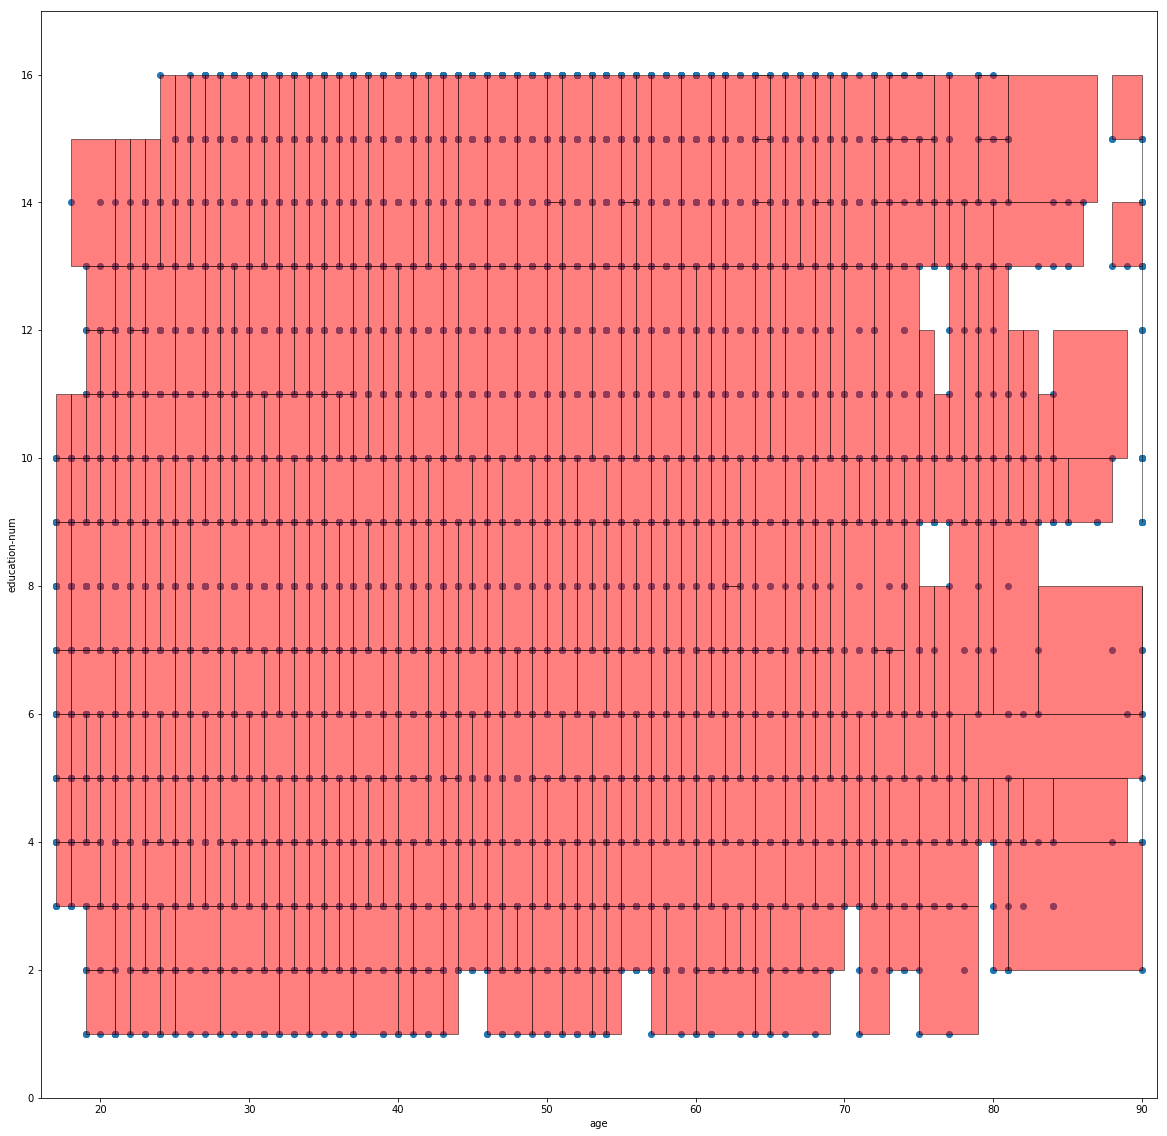

In [16]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, indexes, 
           column_x, column_y, facecolor='r')
# we can also plot the datapoints themselves
pl.scatter(df[column_x], df[column_y])

### Your Turn: Building a K Anonymous Dataset

First, we need to figure out a way to combine columns. How can we define the new values? 


In [19]:
def aggregate_column(series):
    if is_categorical(series):
        return [','.join(set(series))]
    return [series.mean()]

In [27]:
def build_anonymized_dataset(df, partitions, 
                             feature_columns,
                             sensitive_column,
                             max_partitions=None):
    rows = []
    aggregations = {col: aggregate_column for col in feature_columns}
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(
            aggregations)
        sensitive_counts = df.loc[partition].groupby(
            sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,
            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [28]:
dfn = build_anonymized_dataset(df, finished_partitions, 
                               feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...


In [29]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
dfn.sort_values(feature_columns+[sensitive_column])

,age,count,education-num,income
469,17.000000,3,3.000000,<=50k
615,17.000000,5,4.000000,<=50k
110,17.000000,36,5.000000,<=50k
111,17.000000,198,6.000000,<=50k
0,17.000000,334,7.200599,<=50k
120,17.000000,14,9.000000,<=50k
43,17.000000,5,10.000000,<=50k
616,18.000000,6,4.000000,<=50k
329,18.000000,10,5.000000,<=50k
121,18.000000,249,9.000000,<=50k


### Hmmm... Why do some rows only have a count of 1???

In [41]:
dfn.sort_values(['age', 'education-num'])

,age,count,education-num,income
469,17.000000,3,3.000000,<=50k
615,17.000000,5,4.000000,<=50k
110,17.000000,36,5.000000,<=50k
111,17.000000,198,6.000000,<=50k
0,17.000000,334,7.200599,<=50k
120,17.000000,14,9.000000,<=50k
43,17.000000,5,10.000000,<=50k
616,18.000000,6,4.000000,<=50k
329,18.000000,10,5.000000,<=50k
121,18.000000,249,9.000000,<=50k


### Building on K-Anonymity

- l-diversity: Does the group contain more than `l` variations of the sensitive variable?
- t-closeness: Does the group distribution represent the overall distribution of the sensitive variable?
